<a href="https://colab.research.google.com/github/sodiqadewole/AI-Agents/blob/main/Simple_Calculator_Agent_Using_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U langchain-anthropic
!pip install langgraph
!pip install --upgrade langchain-core
!pip install --upgrade langchain
!pip install --upgrade langchain-community

### Define tools and model

In [1]:
from langchain.tools import tool
from langchain.chat_models import init_chat_model


model = init_chat_model(
    "anthropic:claude-sonnet-4-5",
    temperature=0
)


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

### Define state

In [2]:
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

### Define model node

In [3]:
from langchain.messages import SystemMessage


def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

### Define tool node

In [5]:
from langchain.messages import ToolMessage

def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

### Define end logic

In [6]:
from typing import Literal
from langgraph.graph import StateGraph, START, END


def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

### Build and compile the agent

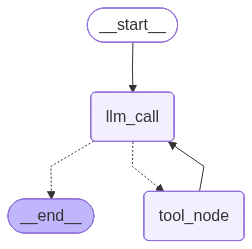

TypeError: "Could not resolve authentication method. Expected either api_key or auth_token to be set. Or for one of the `X-Api-Key` or `Authorization` headers to be explicitly omitted"

In [7]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
from langchain.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

### Full code

In [ ]:
# Step 1: Define tools and model

from langchain.tools import tool
from langchain.chat_models import init_chat_model


model = init_chat_model(
    "anthropic:claude-sonnet-4-5",
    temperature=0
)


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

# Step 2: Define state

from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

# Step 3: Define model node
from langchain.messages import SystemMessage


def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }


# Step 4: Define tool node

from langchain.messages import ToolMessage


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

# Step 5: Define logic to determine whether to end

from typing import Literal
from langgraph.graph import StateGraph, START, END


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

# Step 6: Build agent

# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()


from IPython.display import Image, display
# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
from langchain.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

### Using Functional API

In [8]:
# Step 1: Define tools and model

from langchain.tools import tool
from langchain.chat_models import init_chat_model


model = init_chat_model(
    "anthropic:claude-sonnet-4-5",
    temperature=0
)


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

from langgraph.graph import add_messages
from langchain.messages import (
    SystemMessage,
    HumanMessage,
    ToolCall,
)
from langchain_core.messages import BaseMessage
from langgraph.func import entrypoint, task


# Step 2: Define model node

@task
def call_llm(messages: list[BaseMessage]):
    """LLM decides whether to call a tool or not"""
    return model_with_tools.invoke(
        [
            SystemMessage(
                content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
            )
        ]
        + messages
    )


# Step 3: Define tool node

@task
def call_tool(tool_call: ToolCall):
    """Performs the tool call"""
    tool = tools_by_name[tool_call["name"]]
    return tool.invoke(tool_call)


# Step 4: Define agent

@entrypoint()
def agent(messages: list[BaseMessage]):
    model_response = call_llm(messages).result()

    while True:
        if not model_response.tool_calls:
            break

        # Execute tools
        tool_result_futures = [
            call_tool(tool_call) for tool_call in model_response.tool_calls
        ]
        tool_results = [fut.result() for fut in tool_result_futures]
        messages = add_messages(messages, [model_response, *tool_results])
        model_response = call_llm(messages).result()

    messages = add_messages(messages, model_response)
    return messages

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
for chunk in agent.stream(messages, stream_mode="updates"):
    print(chunk)
    print("\n")

TypeError: "Could not resolve authentication method. Expected either api_key or auth_token to be set. Or for one of the `X-Api-Key` or `Authorization` headers to be explicitly omitted"